In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pickle

df = pd.read_csv("yield_df.csv")
df.drop_duplicates(inplace=True)


df = df[['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'Area', 'Item', 'hg/ha_yield']]


X = df.drop('hg/ha_yield', axis=1)
y = df['hg/ha_yield']

OHE = OneHotEncoder(drop='first', handle_unknown='ignore')
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', scaler, ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']),
        ('onehot', OHE, ['Area', 'Item'])
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=0)


model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R^2 Score: {r2_score(y_test, y_pred):.4f}")


cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R^2: {cv_scores.mean():.4f}")


def predict_yield(rainfall, pesticides, temp, area, item):
    input_data = pd.DataFrame([[rainfall, pesticides, temp, area, item]],
                              columns=['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'Area', 'Item'])
    input_transformed = preprocessor.transform(input_data)
    prediction = model.predict(input_transformed)
    return prediction[0]


result = predict_yield(1485.0, 121.0, 16.37, "Albania", "Maize")
print(f"Predicted Yield: {result:.2f} hg/ha")


pickle.dump(model, open("rf_model.pkl", "wb"))
pickle.dump(preprocessor, open("preprocessor.pkl", "wb"))


MAE: 5585.82
R^2 Score: 0.9768
Cross-Validation R^2: 0.9725
Predicted Yield: 33312.24 hg/ha


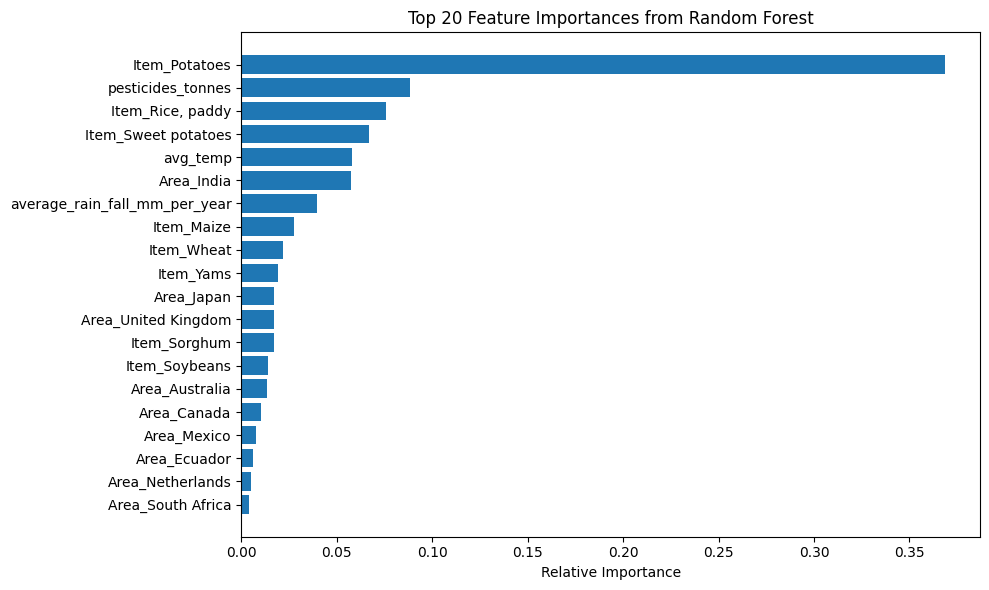

In [ ]:

ohe_features = preprocessor.named_transformers_['onehot'].get_feature_names_out(['Area', 'Item'])
scaled_features = ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
feature_names = list(scaled_features) + list(ohe_features)


importances = model.feature_importances_
indices = np.argsort(importances)[-20:]  

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Top 20 Feature Importances from Random Forest')
plt.tight_layout()
plt.show()


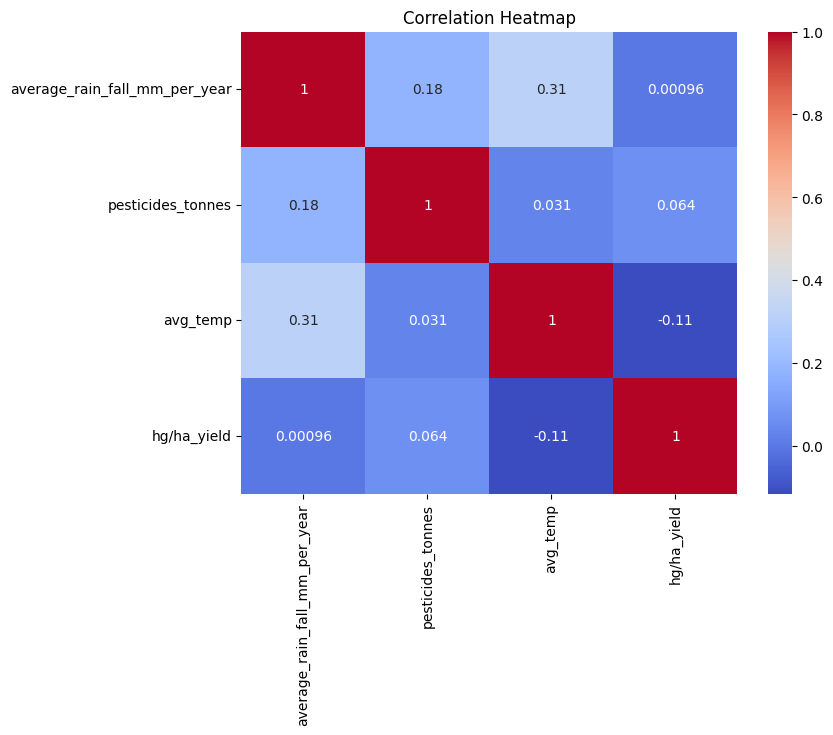

In [4]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'hg/ha_yield']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


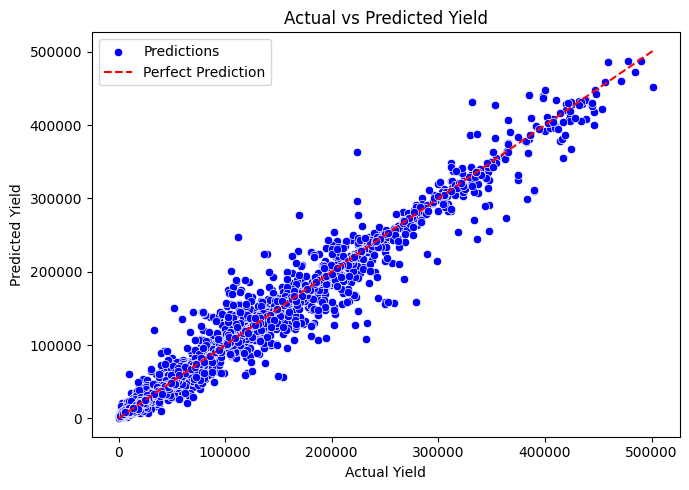

In [8]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred, label="Predictions", color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Yield")
plt.legend()
plt.tight_layout()
plt.show()



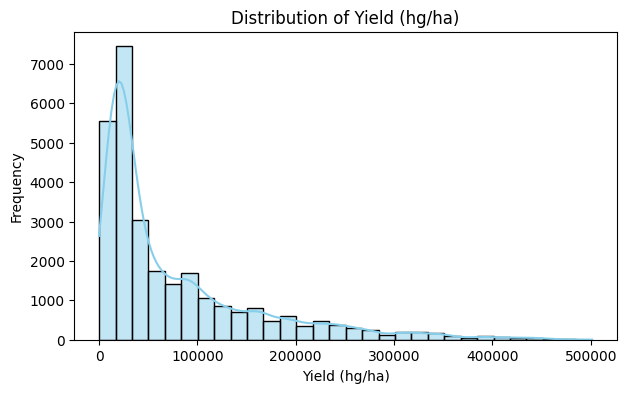

In [9]:
plt.figure(figsize=(7, 4))
sns.histplot(df['hg/ha_yield'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Yield (hg/ha)')
plt.xlabel('Yield (hg/ha)')
plt.ylabel('Frequency')
plt.show()


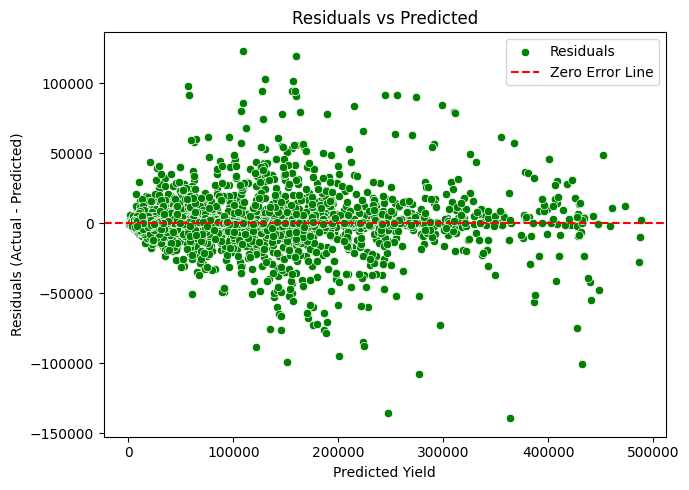

In [10]:
residuals = y_test - y_pred
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred, y=residuals, label="Residuals", color="green")
plt.axhline(0, color='red', linestyle='--', label="Zero Error Line")
plt.xlabel("Predicted Yield")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.legend()
plt.tight_layout()
plt.show()
